This notebook is taken from Nihat Oguz work

In [1]:
from phoenix import potentials, distribution_functions, actions_to_phase_space, sampling
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

We now use our sampling pipeline to generate candidate actions from the total DF.

Number of candidate actions: 500000


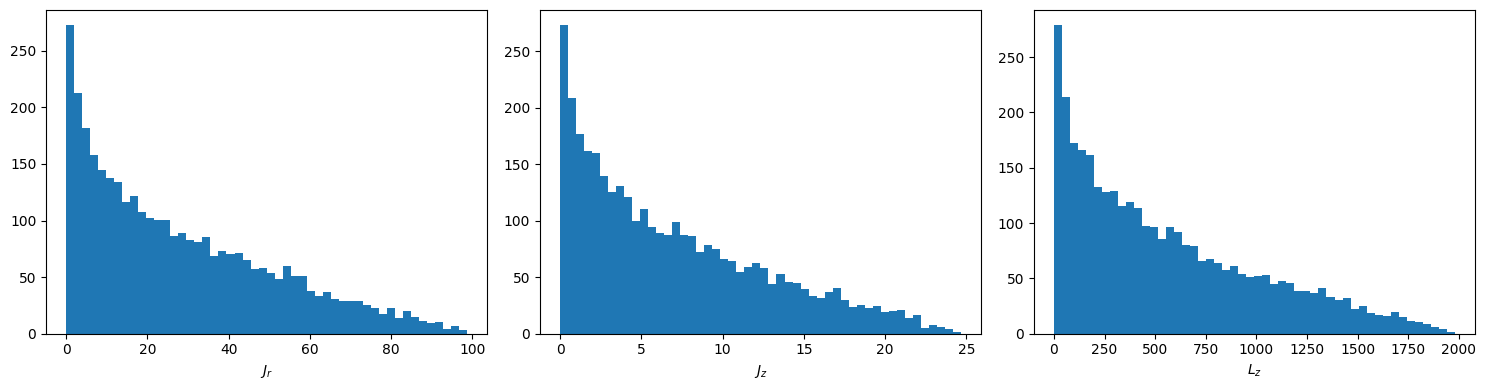

In [2]:
#define parameters
params = {
    "R0": 8.0,
    "Rd": 2.5,
    "v0": 220.0,
    "L0": 50.0,
    "sigma_r0": 40.0,
    "sigma_z0": 20.0,
    "tau_m": 10.0,
    "tau1": 0.1,
    "beta": 0.33,
    "t0": 8.0,
    "n_age_bins": 10,
    "Rd_thick": 2.3,
    "L0_thick": 50.0,
    "sigma_r0_thick": 60.0,
    "sigma_z0_thick": 32.0,
    "frac_thick": 0.2,
    "Z_max": 0.03,
    "Z_min": 0.005,
}

envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

#Generate candidate actions
samples, soft_weights = sampling.sample_df_potential(key, params, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

Now we will convert the sampled actions into positions and velocities.

Phase-space coordinates shape: (500000, 6)


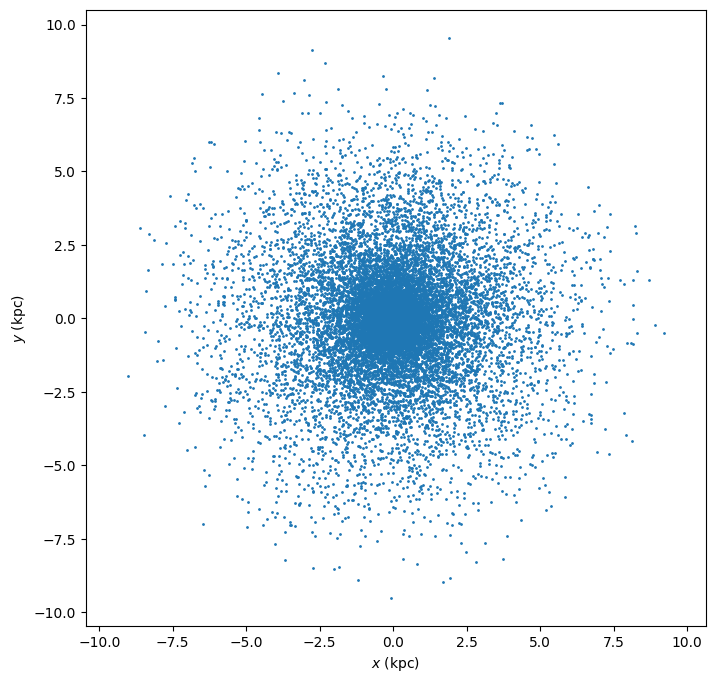

In [3]:
#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key)
print("Phase-space coordinates shape:", phase_space_coords.shape)

#Plot a x-y scatter plot to visualize the distribution
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=1)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.show()

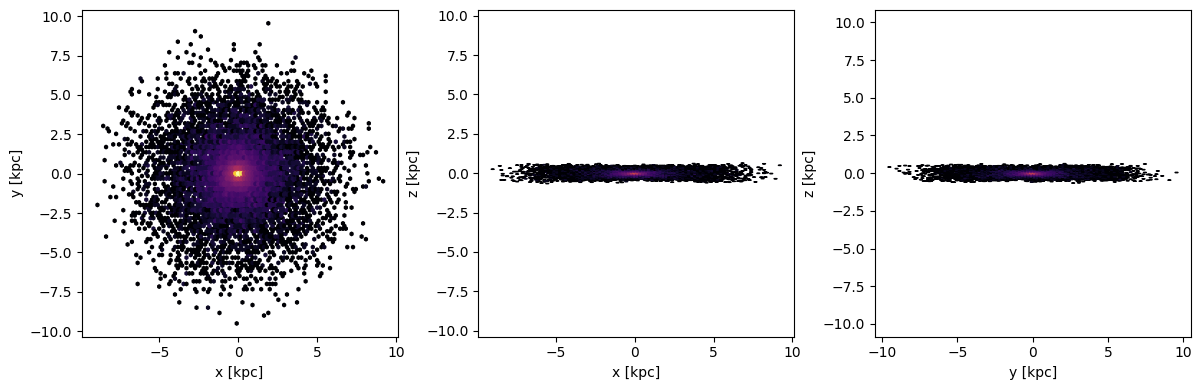

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hexbin(x, y, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hexbin(x, z, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hexbin(y, z, gridsize=100, cmap='inferno', bins='log')
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

This plot shows the 2D histogram of the radial distance R and vertical coordinate z,
which helps to understand the spatial structure of the simulated stellar distribution.

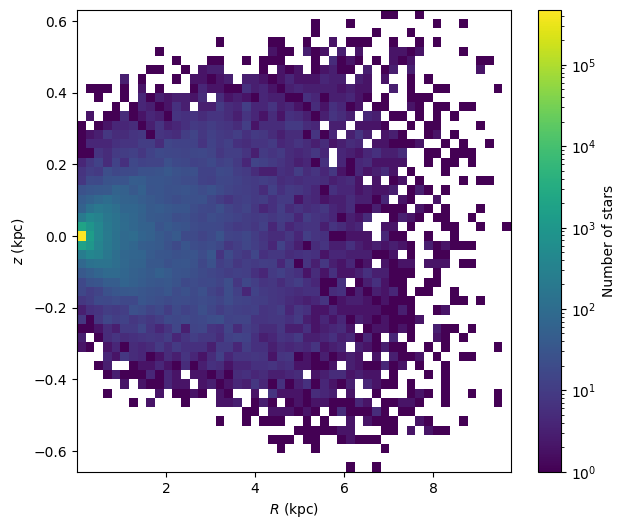

In [5]:
z = phase_space_coords[:, 2]
R = jnp.sqrt(x**2 + y**2)

#Plot a histogram to visualize the distribution
plt.figure(figsize=(7,6))
import matplotlib.colors as colors
plt.hist2d(R, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1)
plt.xlabel(r"$R$ (kpc)")
plt.ylabel(r"$z$ (kpc)")
plt.colorbar(label="Number of stars")
plt.show()

Here we show the histogram of the absolute z-coordinate, indicating the vertical thickness
of the stellar disk.

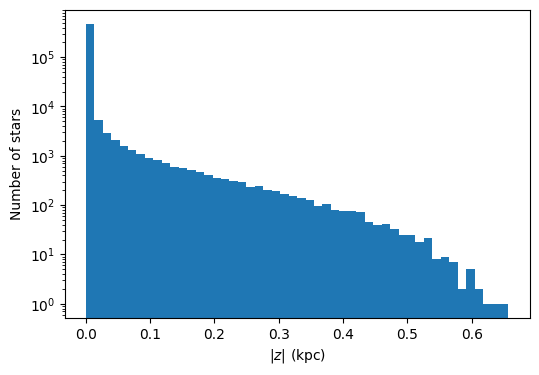

In [6]:
plt.figure(figsize=(6,4))
plt.hist(jnp.abs(z), bins=50)
plt.xlabel(r"$|z|$ (kpc)")
plt.ylabel("Number of stars")
plt.yscale("log")
plt.show()

The following plots display the histograms for the velocity components $v_\text{x}$, $v_\text{y}$
and $v_\text{z}$ of the stars.

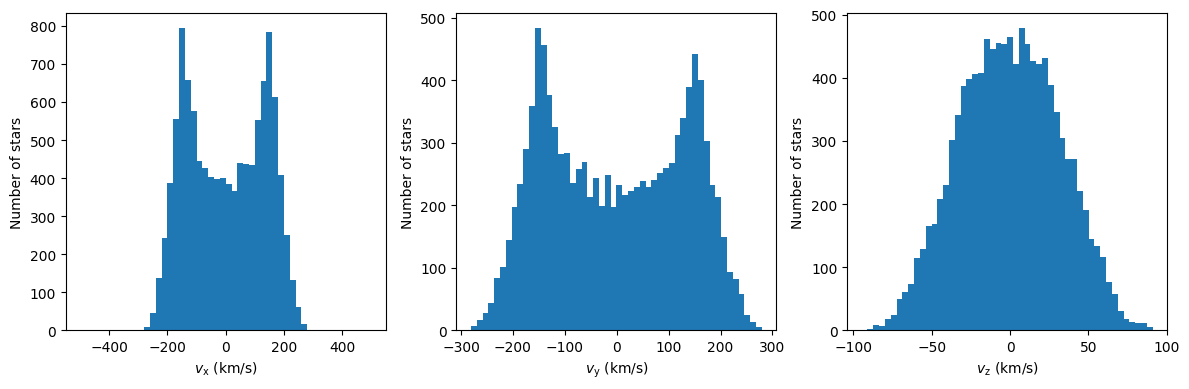

In [7]:
v_x = phase_space_coords[:, 3]
v_y = phase_space_coords[:, 4]
v_z = phase_space_coords[:, 5]

mask = R > 1.0
v_x_masked = v_x[mask]
v_y_masked = v_y[mask]
v_z_masked = v_z[mask]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(v_x_masked, bins=50, range=(-500, 500))
plt.xlabel(r"$v_\text{x}$ (km/s)")
plt.ylabel("Number of stars")


plt.subplot(1,3,2)
plt.hist(v_y_masked, bins=50)
plt.xlabel(r"$v_\text{y}$ (km/s)")
plt.ylabel("Number of stars")

plt.subplot(1,3,3)
plt.hist(v_z_masked, bins=50)
plt.xlabel(r"$v_\text{z}$ (km/s)")
plt.ylabel("Number of stars")
plt.tight_layout()
plt.show()

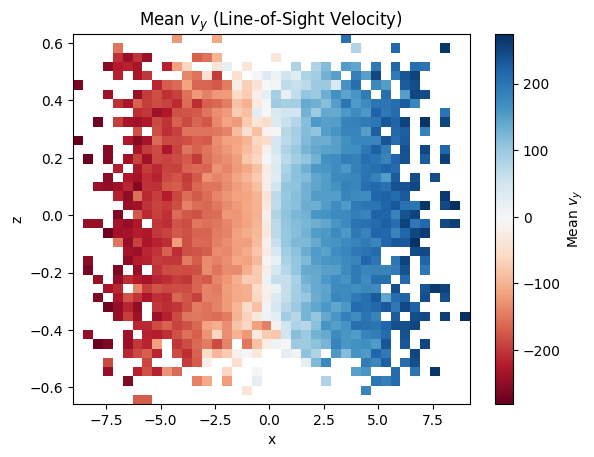

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

num_bins_x = 40
num_bins_z = 40 

# Example: x, z, v_y are 1D arrays of particle positions and velocities
# Define bin edges
x_bins = np.linspace(x.min(), x.max(), num_bins_x + 1)
z_bins = np.linspace(z.min(), z.max(), num_bins_z + 1)

# Digitize positions to bin indices
x_idx = np.digitize(x, x_bins) - 1
z_idx = np.digitize(z, z_bins) - 1

# Initialize array for mean v_y
mean_vy = np.full((num_bins_x, num_bins_z), np.nan)

# Calculate mean v_y for each bin
for i in range(num_bins_x):
    for j in range(num_bins_z):
        mask = (x_idx == i) & (z_idx == j)
        if np.any(mask):
            mean_vy[i, j] = np.mean(v_y[mask])

# Plot with imshow
plt.imshow(mean_vy.T, origin='lower', aspect='auto',
           extent=[x_bins[0], x_bins[-1], z_bins[0], z_bins[-1]],
           cmap='RdBu')#, vmin = np.percentile(mean_vy, 0.001), vmax = np.percentile(mean_vy, 99.999))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Mean $v_y$ (Line-of-Sight Velocity)')
plt.colorbar(label='Mean $v_y$')
#plt.axis('equal')
plt.show()

This section shows the rotation curve derived from the simulated data using $v_\phi = \frac{L_\text{z}}{R} $
and compares it with the theoretical circular velocity $(v_\text{c}(R))$.

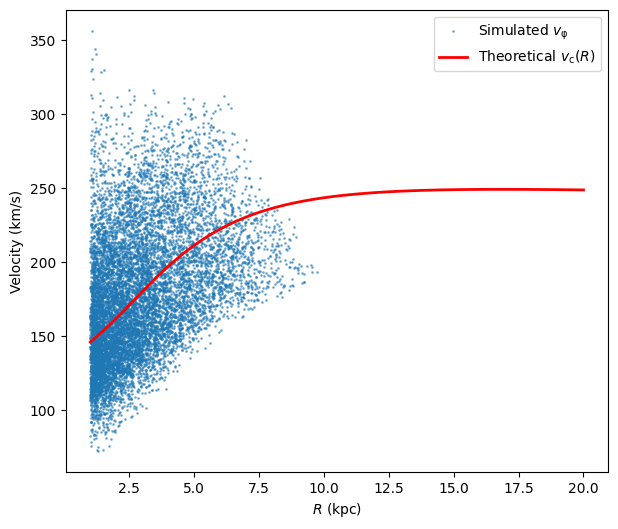

In [9]:
from jax import vmap

#Calculate v_phi from Lz and R
Lz = samples[:, 2]
v_phi = Lz / R

#theoretical circular velocity curve
r_vals = jnp.linspace(1.0, 20, 300)
vc_vals = vmap(potentials.v_c)(r_vals)

plt.figure(figsize=(7,6))
#Scatter plot for simulated v_phi
mask = R > 1.0  #ignoring very inner regions
plt.scatter(R[mask], v_phi[mask], s=1, alpha=0.5, label=r"Simulated $v_{\mathrm{\varphi}}$")
#plot for theoretical v_c(R)
plt.plot(r_vals, vc_vals, color="red", linewidth=2, label=r"Theoretical $v_\mathrm{c}(R)$")

plt.xlabel(r"$R$ (kpc)")
plt.ylabel("Velocity (km/s)")
plt.legend()
plt.show()

In this section, we assign an age (in Gyr) and a metallicity to each star using the 
assign_age_and_metallicity function. The age is obtained from an exponential SFR, 
and the metallicity is interpolated between Z_max and Z_min based on the age.

Below, we plot a histogram of the ages and a scatter plot of the stellar positions 
(x-y) colored by the assigned metallicity.

In [10]:
from phoenix.distribution_functions import assign_age_and_metallicity
n_samples = phase_space_coords.shape[0]
key, subkey = jax.random.split(key)
ages, metallicities = assign_age_and_metallicity(subkey, n_samples, params)

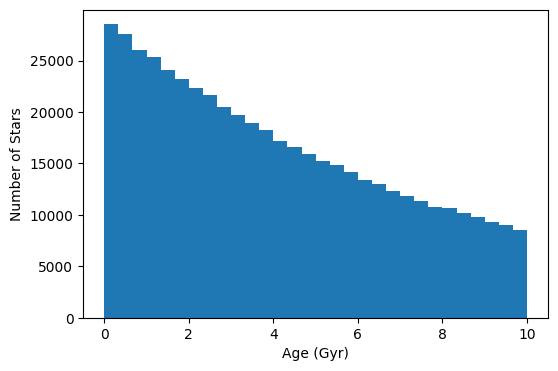

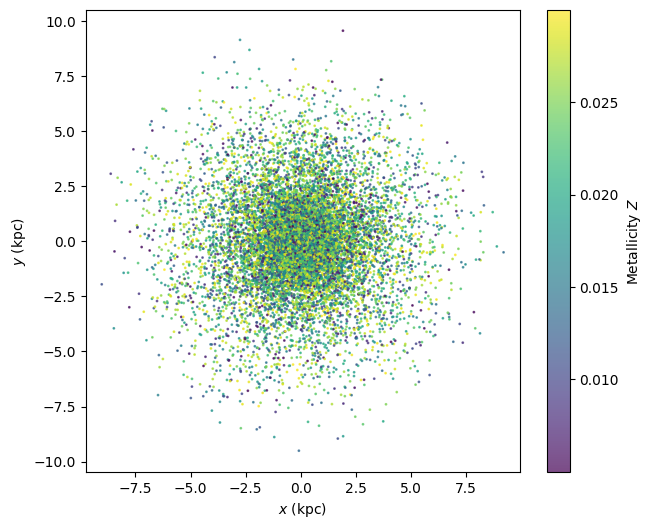

In [11]:
plt.figure(figsize=(6,4))
plt.hist(ages, bins=30)
plt.xlabel("Age (Gyr)")
plt.ylabel("Number of Stars")
plt.show()

x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]

plt.figure(figsize=(7,6))
sc = plt.scatter(x, y, s=1, c=metallicities, cmap="viridis", alpha=0.7)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.colorbar(sc, label=r"Metallicity $Z$")
plt.show()